# devlog 2024-02-12

Development of age-structured IPMs.

Repeating the task of 2024-02-06, but now with a more complex GEO and some movement.

## Assemble GEO

In [ ]:
import os
from functools import partial

import numpy as np
import pandas as pd
from census import Census

census = Census(os.environ.get("CENSUS_API_KEY"))


def query_pop_by_age(state_fips: str, county_fips: str, tract_ids: list[str]):
    query_result = census.acs5.get(
        "group(B01001)",
        geo={
            "for": f'tract:{",".join(tract_ids)}',
            "in": f"state:{state_fips} county:{county_fips}",
        },
        year=2021,
    )

    raw_df = pd.DataFrame.from_records(query_result)

    def group_cols(
        first: int, last: int, *, source: pd.DataFrame, table: str, dtype
    ) -> pd.Series:
        def est_name(line: int) -> str:
            return f"{table}_{line:03d}E"

        result = source[est_name(first)]
        for i in range(first + 1, last + 1):
            result = result + source[est_name(i)]
        return result.astype(dtype)

    group = partial(group_cols, source=raw_df, table="B01001", dtype=np.int64)

    return pd.DataFrame(
        {
            "geoid": raw_df["state"] + raw_df["county"] + raw_df["tract"],
            "population_1": group(3, 8) + group(27, 32),
            "population_2": group(9, 17) + group(33, 41),
            "population_3": group(18, 24) + group(42, 48),
        }
    )


age_df = query_pop_by_age(
    state_fips="04",
    county_fips="013",
    tract_ids=[
        "117300",
        "114000",
        "117200",
        "114900",
        "113204",
        "113301",
        "113202",
        "113100",
        "113000",
        "114100",
        "115300",
        "114200",
        "115400",
        "114301",
        "114401",
        "116800",
        "114302",
        "114402",
        "112900",
        "113900",
        "114800",
    ],
)
# age_df

In [ ]:
from epymorph.data_shape import Shapes
from epymorph.geo.cache import save_to_cache
from epymorph.geo.spec import LABEL, NO_DURATION, AttribDef, StaticGeoSpec
from epymorph.geo.static import StaticGeo
from epymorph.simulation import SimDType

geo = StaticGeo(
    spec=StaticGeoSpec(
        attributes=[
            LABEL,
            AttribDef("population_1", SimDType, Shapes.N),
            AttribDef("population_2", SimDType, Shapes.N),
            AttribDef("population_3", SimDType, Shapes.N),
        ],
        time_period=NO_DURATION,
    ),
    values={
        "label": age_df["geoid"].to_numpy(dtype=np.str_),
        "population": (
            age_df["population_1"] + age_df["population_2"] + age_df["population_3"]
        ).to_numpy(dtype=SimDType),
        "population_1": age_df["population_1"].to_numpy(dtype=SimDType),
        "population_2": age_df["population_2"].to_numpy(dtype=SimDType),
        "population_3": age_df["population_3"].to_numpy(dtype=SimDType),
    },
)

save_to_cache(geo, "devlog-20240212")

## Define IPM

In [1]:
from sympy import Max

from epymorph import *
from epymorph.compartment_model import *

# Basing these age classes on:
# "Age-stratified transmission model of COVID-19 in Ontario with human mobility during pandemic's first wave"; 2021; Fields, et al
# https://doi.org/10.1016%2Fj.heliyon.2021.e07905

# age classes:
# 1: [0,20) years
# 2: [20,60) years
# 3: [60,80) years


def construct_ipm() -> CompartmentModel:
    symbols = create_symbols(
        compartments=[
            compartment("S_1"),
            compartment("S_2"),
            compartment("S_3"),
            compartment("I_1"),
            compartment("I_2"),
            compartment("I_3"),
            compartment("R_1"),
            compartment("R_2"),
            compartment("R_3"),
        ],
        attributes=[
            # infectivity matrix
            param("beta_11", shape=Shapes.TxN),
            param("beta_12", shape=Shapes.TxN),
            param("beta_13", shape=Shapes.TxN),
            param("beta_21", shape=Shapes.TxN),
            param("beta_22", shape=Shapes.TxN),
            param("beta_23", shape=Shapes.TxN),
            param("beta_31", shape=Shapes.TxN),
            param("beta_32", shape=Shapes.TxN),
            param("beta_33", shape=Shapes.TxN),
            # progression from infected to recovered
            param("gamma", shape=Shapes.TxN),
            # progression from recovered to susceptible
            param("xi", shape=Shapes.TxN),
        ],
    )

    [S_1, S_2, S_3, I_1, I_2, I_3, R_1, R_2, R_3] = symbols.compartment_symbols
    [
        beta_11,
        beta_12,
        beta_13,
        beta_21,
        beta_22,
        beta_23,
        beta_31,
        beta_32,
        beta_33,
        gamma,
        xi,
    ] = symbols.attribute_symbols

    N_1 = Max(1, S_1 + I_1 + R_1)
    N_2 = Max(1, S_2 + I_2 + R_2)
    N_3 = Max(1, S_3 + I_3 + R_3)

    return create_model(
        symbols=symbols,
        transitions=[
            # SIR for age class 1
            edge(S_1, I_1, rate=S_1 * beta_11 * I_1 / N_1),
            edge(I_1, R_1, rate=gamma * I_1),
            edge(R_1, S_1, rate=xi * R_1),
            # SIR for age class 2
            edge(S_2, I_2, rate=S_2 * beta_22 * I_2 / N_2),
            edge(I_2, R_2, rate=gamma * I_2),
            edge(R_2, S_2, rate=xi * R_2),
            # SIR for age class 3
            edge(S_3, I_3, rate=S_3 * beta_33 * I_3 / N_3),
            edge(I_3, R_3, rate=gamma * I_3),
            edge(R_3, S_3, rate=xi * R_3),
            # The meta-edges describing the interactions between each age class
            edge(S_1, I_1, rate=S_1 * beta_12 * I_2 / N_2),  # 2 infects 1
            edge(S_1, I_1, rate=S_1 * beta_13 * I_3 / N_3),  # 3 infects 1
            edge(S_2, I_2, rate=S_2 * beta_21 * I_1 / N_1),  # 1 infects 2
            edge(S_2, I_2, rate=S_2 * beta_23 * I_3 / N_3),  # 3 infects 2
            edge(S_3, I_3, rate=S_3 * beta_31 * I_1 / N_1),  # 1 infects 3
            edge(S_3, I_3, rate=S_3 * beta_32 * I_2 / N_2),  # 2 infects 3
        ],
    )


infection_events = [[0, 9, 10], [3, 11, 12], [6, 13, 14]]

## Define initialization

In [7]:
from functools import partial
from typing import Callable

import numpy as np
from numpy.typing import NDArray

from epymorph.initializer import InitContext


def init_empty(ctx: InitContext) -> NDArray[SimDType]:
    _, N, C, _ = ctx.dim.TNCE
    return np.zeros((N, C), dtype=SimDType)


def init_susceptible(
    ctx: InitContext,
    values: NDArray[SimDType],
    *,
    susceptible_compartment: int,
    pop_attribute: str,
) -> NDArray[SimDType]:
    values[:, susceptible_compartment] = ctx.geo[pop_attribute]
    return values


def init_seed(
    ctx: InitContext,
    values: NDArray[SimDType],
    *,
    node: int,
    susceptible_compartment: int,
    infected_compartment: int,
    count: int,
) -> NDArray[SimDType]:
    avail = values[node, susceptible_compartment]
    print(f"Initializer debug: seeding {count} individuals, with {avail} available.")
    values[node, susceptible_compartment] -= count
    values[node, infected_compartment] += count
    return values


def composite_initializer(
    start: Callable[[InitContext], NDArray[SimDType]],
    *transforms: Callable[[InitContext, NDArray[SimDType]], NDArray[SimDType]],
):
    def initializer(ctx: InitContext) -> NDArray[SimDType]:
        value = start(ctx)
        for tx in transforms:
            value = tx(ctx, value)
        return value

    return initializer


initializer = composite_initializer(
    init_empty,
    partial(init_susceptible, susceptible_compartment=0, pop_attribute="population_1"),
    partial(init_susceptible, susceptible_compartment=1, pop_attribute="population_2"),
    partial(init_susceptible, susceptible_compartment=2, pop_attribute="population_3"),
    partial(
        init_seed, node=0, susceptible_compartment=1, infected_compartment=4, count=100
    ),
)

## Set up and run simulation

In [8]:
from functools import reduce

import matplotlib.pyplot as plt

from epymorph.geo.cache import load_from_cache
from epymorph.util import or_raise

geo = or_raise(
    load_from_cache("devlog-20240212"),
    message="Oops, we need to cache the demo geo first (see above cell).",
)

# Construct sim and run
sim = StandardSimulation(
    geo=geo,
    ipm=construct_ipm(),
    mm=mm_library["flat"](),
    params={
        "beta_11": 0.05,
        "beta_12": 0.05,
        "beta_13": 0.05,
        "beta_21": 0.20,
        "beta_22": 0.20,
        "beta_23": 0.20,
        "beta_31": 0.35,
        "beta_32": 0.35,
        "beta_33": 0.35,
        "gamma": 1 / 10,
        "xi": 1 / 90,
        "commuter_proportion": 0.2,
    },
    time_frame=TimeFrame.of("2022-01-01", 165),
    initializer=initializer,
    # rng=default_rng(1),
)

with sim_messaging(sim):
    out = sim.run()
    # calc total new infections (depending on the IPM this may represent this as separate events)
    infections = np.array(
        [
            reduce(
                lambda a, b: a + b,
                (
                    out.incidence_per_day[:, :, j].sum(axis=1)
                    for j in infection_events[i]
                ),
            )
            for i in [0, 1, 2]
        ]
    )

Initializer debug: seeding 100 individuals, with 2829 available.
Running simulation (StandardSimulation):
• 2022-01-01 to 2022-06-15 (165 days)
• 21 geo nodes
|####################| 100% 
Runtime: 2.722s


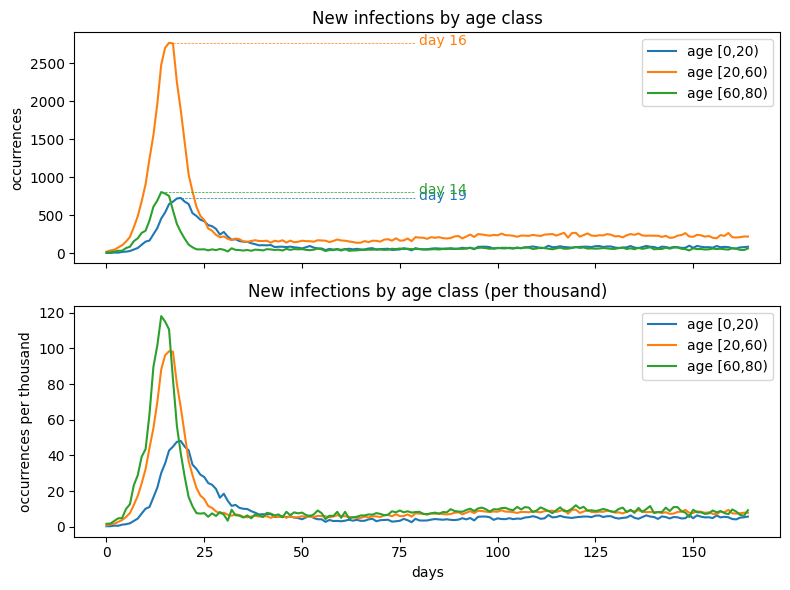

In [9]:
# Plot results
age_label = ["age [0,20)", "age [20,60)", "age [60,80)"]
age_total_thousands = (
    np.column_stack(
        [geo["population_1"], geo["population_2"], geo["population_3"]]
    ).sum(axis=0)
    / 1000
)
t_window = slice(0, None)

# Day of Peak Infection by age class
dpi = [int(np.argmax(infections[i])) for i in [0, 1, 2]]
max_y_value = infections.max()
dpi_x_pos = 80  # an absolute x offset (to keep them horizontally aligned)
dpi_y_pos = -0.01 * max_y_value  # an offset from the peak's y position

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))
x_axis = np.arange(out.dim.days)[t_window]

ax1.set_title("New infections by age class")
ax1.set_ylabel("occurrences")
for i in [0, 1, 2]:
    color = ax1._get_lines.get_next_color()
    y_axis = infections[i][t_window]
    ax1.plot(x_axis, y_axis, color=color, label=age_label[i])
    # Mark day of peak infection
    d = dpi[i]
    ax1.text(dpi_x_pos, y_axis[d] + dpi_y_pos, f"day {d}", color=color)
    ax1.hlines(
        y=y_axis[d],
        xmin=d,
        xmax=dpi_x_pos - 1,
        color=color,
        linewidth=0.5,
        linestyle="dashed",
    )
ax1.legend()

ax2.set_title("New infections by age class (per thousand)")
ax2.set_xlabel("days")
ax2.set_ylabel("occurrences per thousand")
for i in [0, 1, 2]:
    y_axis = infections[i][t_window] / age_total_thousands[i]
    ax2.plot(x_axis, y_axis, label=age_label[i])
ax2.legend()

fig.tight_layout()
plt.show()